In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns

import rasterio
import geopandas as gpd
import rasterio as rio
import rasterio.plot as rioplot
from glob import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

ModuleNotFoundError: No module named 'rasterio'

In [ ]:
# 477 actual methodology data around Redding CA
ca_broadband = pd.read_csv("./Data/fcc477actual/CA_201906.csv")

# Loading Redding CA census blocks shapefile
# Download from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
ca_shp = gpd.read_file("./Data/shapefiles/censusblocks/ca/tl_2019_06_tabblock10.shp")

redd = gpd.read_file("./Data/geojson/redding.json")

# Combining the two into one dataframe
def merge_data(shp,bbnd):
    shp = shp.set_index("GEOID10")
    shp.index = shp.index.map(int)
    
    bbnd = bbnd.set_index("FIPS")
    bbnd.index = bbnd.index.map(int)
    return shp.merge(bbnd,left_index=True, right_index=True, how="inner")

ca_merged = merge_data(ca_shp,ca_broadband)
ovr_redd = gpd.overlay(redd, ca_merged)

Text(0.5, 1, '4G LTE Coverage around Redding')

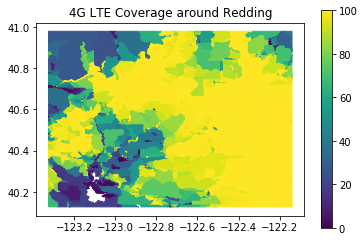

In [221]:
# Taking a quick peek at the 4G coverage around Redding
ovr_redd.plot(cmap="viridis",legend=True,column="4G_LTE",edgecolor="face", linewidth=1)
pp.title("4G LTE Coverage around Redding")

In [560]:
bndfiles = np.sort(glob("./Data/landsat/ca/redding/*B[1-7].TIF"))
sat_redd, sat_redd_meta = es.stack(bndfiles,nodata=0)

<Figure size 720x720 with 0 Axes>

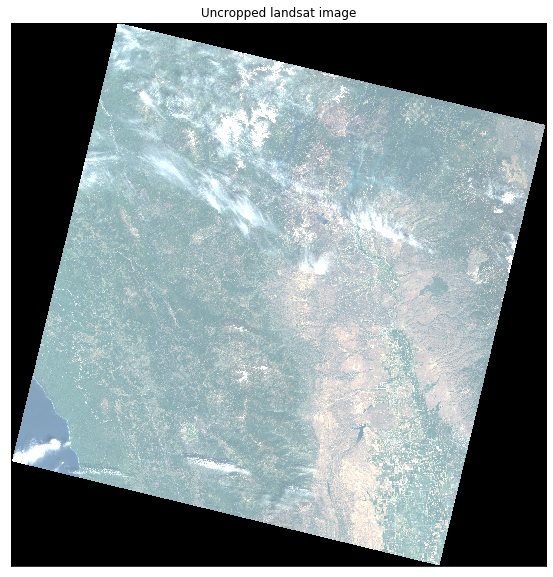

In [547]:
pp.figure(figsize=(10,10))
ep.plot_rgb(sat_redd, rgb=(3,2,1),stretch=True,title="Uncropped landsat image")

In [562]:
crppths = es.crop_all(bndfiles,"./Data/landsat/ca/",shp_redd.to_crs(sat_redd_meta["crs"]),overwrite=True);
crop_redd, crop_redd_meta = es.stack(crppths)

C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [563]:
# Creating a raster from the data on 4G coverage in census blocks
ovr_crs = ovr_redd.to_crs(crop_redd_meta["crs"])
shapes = [(geom,value) for geom, value in zip(ovr_crs["geometry"],ovr_crs["4G_LTE"])]
raster_4g = rio.features.rasterize(shapes,np.shape(crop_redd[0]),transform=crop_redd_meta["transform"])
crop_redd[6,:,:] = raster_4g

C:\Users\Tyler\anaconda3\envs\cs230\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


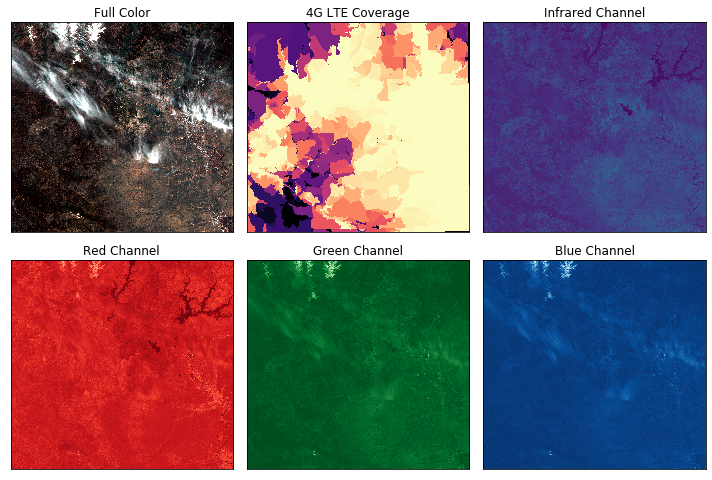

In [564]:
# Making a super hacky plots of the satellite data
pp.figure(figsize=(10,10))
colors = [["Blue Channel","Blues_r",6], 
          ["Green Channel","Greens_r",5],
          ["Red Channel","Reds_r",4], 
          ["Infrared Channel","viridis",3],
         ["4G LTE Coverage","magma",2]]     
        
for i,j in enumerate(range(2,7)):
    pp.subplot(2,3,colors[i][2])
    pp.imshow(crop_redd[j],cmap=colors[i][1])
    pp.title(colors[i][0])
    pp.xticks([])
    pp.yticks([])
    
pp.subplot(231)
rgb_crop = ep._stretch_im(crop_redd,2)
rgb_crop = rgb_crop.transpose([1,2,0])[:,:,[2,1,0]]/np.max(rgb_crop.T[:,:,:4])
pp.imshow(rgb_crop)
pp.title("Full Color")
pp.xticks([])
pp.yticks([])

pp.tight_layout(h_pad=-15)